In [12]:
import numpy as np
import os
import sys
import time
import pandas as pd 
from tqdm._tqdm_notebook import tqdm_notebook
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging

In [48]:
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 10,
    "lr": 0.00010000,
    "time_steps": 60
}

iter_changes = "dropout_layers_0.4_0.4"

path = os.path.abspath('')
print("Path: "+path)
INPUT_PATH = path
OUTPUT_PATH = path+"/outputs/lstm_best_7-3-19_12AM/"+iter_changes
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
stime = time.time()

Path: /Users/saicoumar/Desktop/TartanHacksFinancialAdvice


In [14]:
def print_time(text, stime):
    seconds = (time.time()-stime)
    print(text, seconds//60,"minutes : ",np.round(seconds%60),"seconds")
    
def trim_dataset(mat,batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [15]:
def build_timeseries(mat, y_col_index):
    """
    Converts ndarray into timeseries format and supervised data format. Takes first TIME_STEPS
    number of rows as input and sets the TIME_STEPS+1th data as corresponding output and so on.
    :param mat: ndarray which holds the dataset
    :param y_col_index: index of column which acts as output
    :return: returns two ndarrays-- input and output in format suitable to feed
    to LSTM.
    """
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
#         if i < 10:
#           print(i,"-->", x[i,-1,:], y[i])
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [16]:
stime = time.time()
print(os.listdir(INPUT_PATH))
df_ge = pd.read_csv(os.path.join(INPUT_PATH, "ge.us.txt"), engine='python')
print(df_ge.columns)
print(df_ge.shape)
print("value: ")
date = df_ge.iloc[-1]['Date'] +""
year = date[0:4]
print(year)
print(df_ge.head(5))
tqdm_notebook.pandas('Processing...')
# df_ge = process_dataframe(df_ge)
print(df_ge.dtypes)
train_cols = ["Open","High","Low","Close","Volume"]
df_train, df_test = train_test_split(df_ge, train_size=0.8, test_size=0.2, shuffle=False)
print("Train--Test size", len(df_train), len(df_test))

['.DS_Store', 'chooseData.py', 'LSTM.ipynb', 'archive', 'lstm_model', 'ge.us.txt', '.ipynb_checkpoints', '.git', 'main.py', 'outputs']
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'], dtype='object')
(14058, 7)
value: 
2017
         Date    Open    High     Low   Close   Volume  OpenInt
0  1962-01-02  0.6277  0.6362  0.6201  0.6201  2575579        0
1  1962-01-03  0.6201  0.6201  0.6122  0.6201  1764749        0
2  1962-01-04  0.6201  0.6201  0.6037  0.6122  2194010        0
3  1962-01-05  0.6122  0.6122  0.5798  0.5957  3255244        0
4  1962-01-08  0.5957  0.5957  0.5716  0.5957  3696430        0
Date        object
Open       float64
High       float64
Low        float64
Close      float64
Volume       int64
OpenInt      int64
dtype: object
Train--Test size 11246 2812


/Users/saicoumar/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [17]:
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

print("Deleting unused dataframes of total size(KB)",(sys.getsizeof(df_ge)+sys.getsizeof(df_train)+sys.getsizeof(df_test))//1024)

del df_ge
del df_test
del df_train
del x

Deleting unused dataframes of total size(KB) 3267


In [18]:
print("Are any NaNs present in train/test matrices?",np.isnan(x_train).any(), np.isnan(x_train).any())
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
print("Batch trimmed size",x_t.shape, y_t.shape)

Are any NaNs present in train/test matrices? False False
dim_0 11186



length of time-series i/o (11186, 60, 5) (11186,)
Batch trimmed size (11180, 60, 5) (11180,)


In [22]:
def create_model():
    lstm_model = Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(LSTM(60, dropout=0.0))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(20,activation='relu'))
    lstm_model.add(Dense(1,activation='sigmoid'))
    optimizer = optimizers.RMSprop(lr=params["lr"])
    # optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    return lstm_model


model = None
try:
    model = pickle.load(open("lstm_model", 'rb'))
    print("Loaded saved model...")
except FileNotFoundError:
    print("Model not found")

Model not found


In [23]:

x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)

dim_0 2752



length of time-series i/o (2752, 60, 5) (2752,)
Test size (1370, 60, 5) (1370,) (1370, 60, 5) (1370,)


In [24]:
is_update_model = True
if model is None or is_update_model:
    from keras import backend as K
    print("Building model...")
#     print("checking if GPU available", K.tensorflow_backend._get_available_gpus())
    model = create_model()
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.0001)
    
    mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,
                          "best_model.h5"), monitor='val_loss', verbose=1,
                          save_best_only=True, save_weights_only=False, mode='min', period=1)

    # Not used here. But leaving it here as a reminder for future
    r_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, 
                                  verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
    csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'training_log_' + time.ctime().replace(" ","_") + '.log'), append=True)
    
    history = model.fit(x_t, y_t, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, r_lr_plat, mcp])
    
    print("saving model...")
#     pickle.dump(model, open("lstm_model", "wb"))


Building model...
Epoch 1/10
559/559 - 17s - loss: 0.0154 - val_loss: 0.0273

Epoch 00001: val_loss improved from inf to 0.02732, saving model to /Users/saicoumar/Desktop/TartanHacksFinancialAdvice/outputs/lstm_best_7-3-19_12AM/dropout_layers_0.4_0.4/best_model.h5
Epoch 2/10
559/559 - 14s - loss: 0.0040 - val_loss: 0.0052

Epoch 00002: val_loss improved from 0.02732 to 0.00517, saving model to /Users/saicoumar/Desktop/TartanHacksFinancialAdvice/outputs/lstm_best_7-3-19_12AM/dropout_layers_0.4_0.4/best_model.h5
Epoch 3/10
559/559 - 17s - loss: 0.0019 - val_loss: 0.0049

Epoch 00003: val_loss improved from 0.00517 to 0.00493, saving model to /Users/saicoumar/Desktop/TartanHacksFinancialAdvice/outputs/lstm_best_7-3-19_12AM/dropout_layers_0.4_0.4/best_model.h5
Epoch 4/10
559/559 - 17s - loss: 0.0018 - val_loss: 0.0047

Epoch 00004: val_loss improved from 0.00493 to 0.00473, saving model to /Users/saicoumar/Desktop/TartanHacksFinancialAdvice/outputs/lstm_best_7-3-19_12AM/dropout_layers_0.4_

In [41]:

# model.evaluate(x_test_t, y_test_t, batch_size=BATCH_SIZE
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])


Error is 0.0019608937529431644 (1360,) (1360,)
[0.3910833  0.3907925  0.39023873 0.38970628 0.38937032 0.38890627
 0.38856673 0.38846543 0.38843167 0.38840836 0.38836753 0.38911045
 0.38854912 0.38798785 0.38713256]
[0.32378063 0.32499919 0.32800358 0.32905407 0.32905407 0.33031465
 0.32943225 0.33205846 0.32659593 0.32747834 0.31770881 0.31092267
 0.31258244 0.32378063 0.32592362]
[19.073404 19.059563 19.033207 19.007864 18.991873 18.969786 18.953625
 18.948803 18.947195 18.946087 18.944143 18.979504 18.952785 18.926071
 18.88536 ]
[15.87  15.928 16.071 16.121 16.121 16.181 16.139 16.264 16.004 16.046
 15.581 15.258 15.337 15.87  15.972]


Stuff
[[[0.33259297 0.32832695 0.32936486 0.3297684  0.44697045]
  [0.32923088 0.32951465 0.32921638 0.33138615 0.49479186]
  [0.33403084 0.32951465 0.33167688 0.33012557 0.2582635 ]
  ...
  [0.32479038 0.32026313 0.32115611 0.31886435 0.50946889]
  [0.31999041 0.3172418  0.31704114 0.31529269 0.5158963 ]
  [0.32603795 0.32757683 0.32399842 0.32592362 0.92419152]]

 [[0.32923088 0.32951465 0.32921638 0.33138615 0.49479186]
  [0.33403084 0.32951465 0.33167688 0.33012557 0.2582635 ]
  [0.32853308 0.32849365 0.32883457 0.32712117 0.40643564]
  ...
  [0.31999041 0.3172418  0.31704114 0.31529269 0.5158963 ]
  [0.32603795 0.32757683 0.32399842 0.32592362 0.92419152]
  [0.32745468 0.32532646 0.32688314 0.32378063 0.42395503]]

 [[0.33403084 0.32951465 0.33167688 0.33012557 0.2582635 ]
  [0.32853308 0.32849365 0.32883457 0.32712117 0.40643564]
  [0.32975951 0.3263683  0.32902548 0.32873892 0.37919709]
  ...
  [0.32603795 0.32757683 0.32399842 0.32592362 0.92419152]
  [0.32745468 0.32532646 0.3

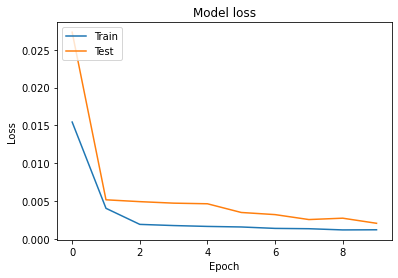

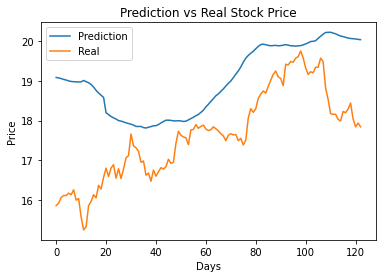

In [52]:
# Visualize the training data
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'train_vis_BS_'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))

# load the saved best model from above
saved_model = load_model(os.path.join(OUTPUT_PATH, 'best_model.h5')) # , "lstm_best_7-3-19_12AM",
print(saved_model)
print("Stuff")
print(trim_dataset(x_test_t, BATCH_SIZE))
print(BATCH_SIZE)
y_pred = saved_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()

y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])
print("unga bunga")
print(min_max_scaler.data_range_[3])
print(min_max_scaler.data_min_[3])
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org[0:123])
plt.plot(y_test_t_org[0:123])
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
#plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))
print_time("program completed ", stime)
